## 4. Arrhythmia Detection and Classification

### Imports

In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

### Read the data

In [39]:
# Load RR intervals (make sure the path matches where you saved it)
rr_intervals = np.load('../data/rr_intervals.npy')

features = pd.DataFrame({
    'rr_interval': rr_intervals,
    'heart_rate': 60 / rr_intervals
})

# Label: 0 = normal, 1 = abnormal
features['label'] = features['heart_rate'].apply(lambda x: 0 if 60 <= x <= 100 else 1)

print("Sample features with labels:")
print(features.head())

Sample features with labels:
   rr_interval  heart_rate  label
0     0.813889   73.720137      0
1     0.811111   73.972603      0
2     0.788889   76.056338      0
3     0.791667   75.789474      0
4     0.788889   76.056338      0


#### 1. Rule-based Classification (Normal/Abnormal by Heart Rate)

In [40]:
# Calculate average heart rate for the whole signal
mean_rr = np.mean(rr_intervals)
heart_rate = 60 / mean_rr
if 60 <= heart_rate <= 100:
    label = 'Normal'
else:
    label = 'Abnormal (Possible Arrhythmia)'

print(f"Heart Rate: {heart_rate:.2f} bpm")
print(f"Classification: {label}")

Heart Rate: 75.51 bpm
Classification: Normal


### 2. Prepare Features for Machine Learning
- Average heart rate
- Standard deviation of RR intervals (HRV)
- Min/max RR interval
- Number of RR intervals < 0.6s or > 1.0s

In [41]:
def extract_features(rr_intervals):
    features = {
        'mean_rr': np.mean(rr_intervals),
        'std_rr': np.std(rr_intervals),
        'min_rr': np.min(rr_intervals),
        'max_rr': np.max(rr_intervals),
        'num_short_rr': np.sum(rr_intervals < 0.6),
        'num_long_rr': np.sum(rr_intervals > 1.0),
    }
    return list(features.values())

# Example for one record
X = [extract_features(rr_intervals)]
y = [1 if label == 'Abnormal (Possible Arrhythmia)' else 0]  # 1=Abnormal, 0=Normal

### 3. Machine Learning Classifier 


### Train-test split

In [42]:
X = features[['rr_interval', 'heart_rate']]
y = features['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1. Train a Random Forest Classifier

In [21]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

### - Performance metrics


In [15]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       1.00      1.00      1.00         7

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

Confusion Matrix:
 [[448   0]
 [  0   7]]


- True Negatives (TN): 448 (normal correctly classified)
- False Positives (FP): 0 (normal misclassified as abnormal)
- False Negatives (FN): 0 (abnormal misclassified as normal)
- True Positives (TP): 7 (abnormal correctly classified)

### - ROC Curve

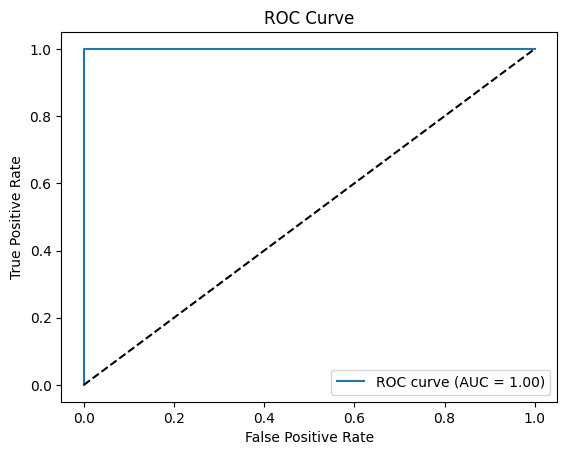

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 2.Logistic Regression

In [28]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression:")
# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logreg))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       448
           1       1.00      0.29      0.44         7

    accuracy                           0.99       455
   macro avg       0.99      0.64      0.72       455
weighted avg       0.99      0.99      0.99       455

Confusion Matrix:
 [[448   0]
 [  5   2]]


- True Negatives (TN): 448 (normal correctly classified)
- False Positives (FP): 0 (normal misclassified as abnormal)
- False Negatives (FN): 5 (abnormal misclassified as normal)
- True Positives (TP): 2 (abnormal correctly classified)

### - ROC

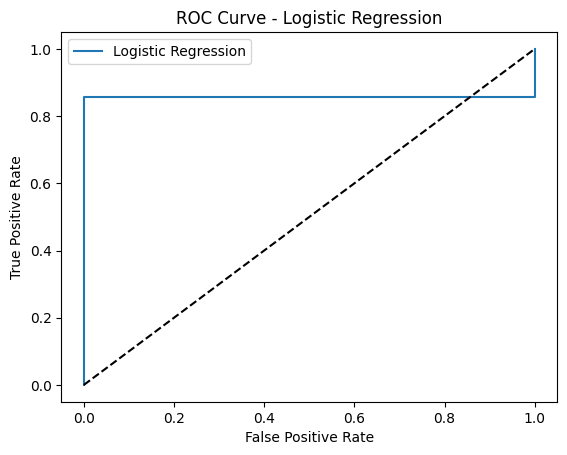

In [29]:
y_prob_logreg = logreg.predict_proba(X_test)[:,1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_logreg)
plt.figure()
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

### 3. Decision Tree

In [32]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_test)
# Print classification report and confusion matrix
print("Decision Tree:")
print(classification_report(y_test, y_pred_dtree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dtree))

Decision Tree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       448
           1       1.00      1.00      1.00         7

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455

Confusion Matrix:
 [[448   0]
 [  0   7]]


- True Negatives (TN): 448 (normal correctly classified)
- False Positives (FP): 0 (normal misclassified as abnormal)
- False Negatives (FN): 0 (abnormal misclassified as normal)
- True Positives (TP): 7 (abnormal correctly classified)

### - ROC Curve

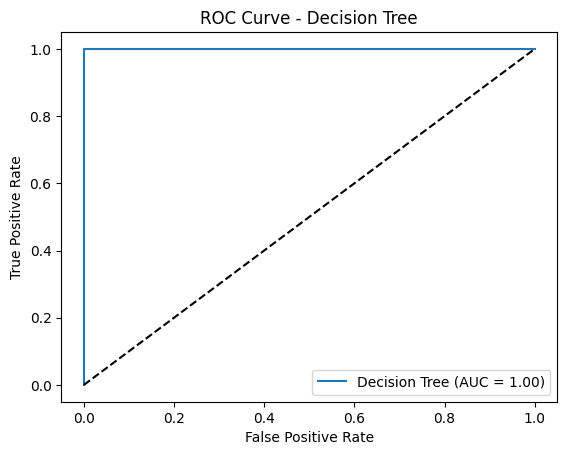

In [33]:
y_prob_dtree = dtree.predict_proba(X_test)[:,1]
fpr_dtree, tpr_dtree, _ = roc_curve(y_test, y_prob_dtree)
roc_auc_dtree = auc(fpr_dtree, tpr_dtree)
plt.figure()
plt.plot(fpr_dtree, tpr_dtree, label=f'Decision Tree (AUC = {roc_auc_dtree:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.show()

### 4. Support Vector Machine (SVM)

In [35]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
# Print classification report and confusion matrix
print("SVM:")
print(classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


SVM:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       448
           1       1.00      0.43      0.60         7

    accuracy                           0.99       455
   macro avg       1.00      0.71      0.80       455
weighted avg       0.99      0.99      0.99       455

Confusion Matrix:
 [[448   0]
 [  4   3]]


- True Negatives (TN): 448 (normal correctly classified)
- False Positives (FP): 0 (normal misclassified as abnormal)
- False Negatives (FN): 4 (abnormal misclassified as normal)
- True Positives (TP): 3 (abnormal correctly classified)

### - ROC Curve

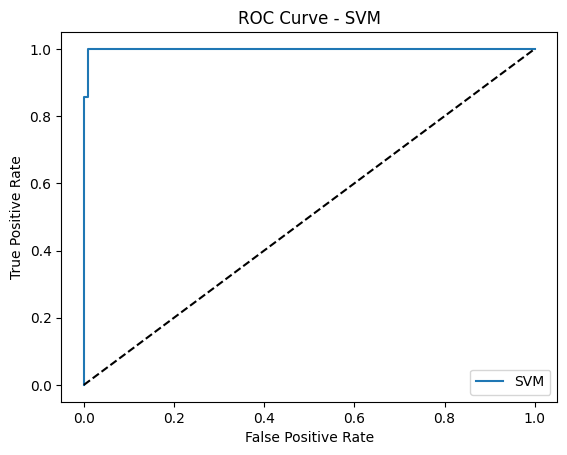

In [36]:
y_prob_svm = svm.predict_proba(X_test)[:,1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.show()